# PROBLEM STATEMENT:
Given the Yeast Dataset, where each data point (instance) represents an experiment, and the features are gene expression levels. The target is a set of 14 functional categories (labels) to which the gene product may belong (multi-label classification). This dataset, despite being standardized, can still exhibit data veracity issue like:

1.Noisy/Ambiguous Labels: Genes whose functions span multiple categories or are misclassified.

2.Outliers: Experiments with highly unusual gene expression profiles.

3.Hard-to-Learn Samples: Data points lying in regions where functional categories are thoroughly mixed.

Apply t-SNE and Isomap to the feature vectors to visually expose these data quality issues, thereby understanding the challenges a classifier would face.

# Part A: Preprocessing and Initial Setup [10 points]

## A.1 Data loading

In [1]:
# Install liac-arff if not already installed
!pip install liac-arff

import pandas as pd
import numpy as np
import arff

# Load the ARFF file (assumes 'yeast.arff' is in your present working directory)
with open('yeast.arff', 'r') as f:
    dataset = arff.load(f)

data = np.array(dataset['data'])
columns = [attr[0] for attr in dataset['attributes']]
df = pd.DataFrame(data, columns=columns)

# Show shape and the first 5 rows
print("Shape:", df.shape)



  Preparing metadata (setup.py) ... done
  Created wheel for liac-arff: filename=liac_arff-2.5.0-py3-none-any.whl size=11717 sha256=63d670bf5649632cf95735d376b343bfc006128bb34eea7431a319759596bc81
  Stored in directory: /root/.cache/pip/wheels/a9/ac/cf/c2919807a5c623926d217c0a18eb5b457e5c19d242c3b5963a
Successfully built liac-arff
Shape: (2417, 117)


In [2]:
from IPython.display import display, HTML

# Set pandas option to show more columns
pd.set_option('display.max_columns', 120)        # You can increase the number if needed
pd.set_option('display.width', None)


# Show top 10 rows in a scrollable table
display(HTML(df.head(10).to_html()))




,Att1,Att2,Att3,Att4,Att5,Att6,Att7,Att8,Att9,Att10,Att11,Att12,Att13,Att14,Att15,Att16,Att17,Att18,Att19,Att20,Att21,Att22,Att23,Att24,Att25,Att26,Att27,Att28,Att29,Att30,Att31,Att32,Att33,Att34,Att35,Att36,Att37,Att38,Att39,Att40,Att41,Att42,Att43,Att44,Att45,Att46,Att47,Att48,Att49,Att50,Att51,Att52,Att53,Att54,Att55,Att56,Att57,Att58,Att59,Att60,Att61,Att62,Att63,Att64,Att65,Att66,Att67,Att68,Att69,Att70,Att71,Att72,Att73,Att74,Att75,Att76,Att77,Att78,Att79,Att80,Att81,Att82,Att83,Att84,Att85,Att86,Att87,Att88,Att89,Att90,Att91,Att92,Att93,Att94,Att95,Att96,Att97,Att98,Att99,Att100,Att101,Att102,Att103,Class1,Class2,Class3,Class4,Class5,Class6,Class7,Class8,Class9,Class10,Class11,Class12,Class13,Class14
0,0.004168,-0.170975,-0.156748,-0.142151,0.058781,0.026851,0.197719,0.04185,0.066938,-0.056617,-0.02723,-0.137411,0.067776,0.047175,0.155671,0.050766,0.102557,-0.020259,-0.200512,-0.095371,-0.08194,-0.103735,0.093299,0.105475,0.14856,0.085925,0.107879,0.108075,0.085388,0.124026,-0.00365,-0.127376,0.039394,-0.018364,0.050378,0.15719,0.203563,0.111552,0.017907,-0.001126,0.053062,0.140708,0.137118,-0.090282,-0.067809,-0.102396,-0.051758,0.050665,0.007055,0.021674,0.061283,0.083523,0.053235,0.001978,0.077418,0.046762,-0.07573,-0.092787,0.127297,-0.178029,-0.202705,-0.028543,0.032891,0.023189,0.009716,-0.169848,-0.002261,-0.133029,0.082378,-0.21661,0.062425,-0.128243,0.203676,0.143642,0.178602,0.192041,0.154135,-0.175325,-0.133636,0.005524,-0.014981,-0.031946,-0.015114,-0.047175,0.003829,0.010967,-0.006062,-0.02756,-0.019866,-0.024046,-0.025153,-0.009261,-0.025539,0.006166,-0.012976,-0.014259,-0.015024,-0.010747,0.000411,-0.032056,-0.018312,0.030126,0.124722,0,0,0,0,0,0,1,1,0,0,0,1,1,0
1,-0.103956,0.011879,-0.098986,-0.054501,-0.00797,0.049113,-0.03058,-0.077933,-0.080529,-0.016267,-0.215304,-0.009885,-0.155843,-0.059522,-0.098836,-0.071141,-0.023494,-0.0712,0.027767,0.003091,-0.003761,0.0746,0.05308,-0.008138,0.001794,-0.111704,-0.140291,-0.063347,0.066767,-0.167073,-0.095567,-0.047209,0.082206,0.144445,0.086581,-0.11185,-0.08656,0.024942,-0.131539,0.080062,0.345095,-0.090835,-0.072651,0.045934,0.016653,-0.09112,0.024707,-0.058299,0.02721,0.004696,0.013844,0.043541,0.044008,0.03648,0.039348,-0.046261,0.025664,0.016511,0.043803,0.019016,-0.018508,-0.042825,-0.127017,0.383213,0.027688,0.179844,-0.019807,0.031726,-0.086455,0.157766,-0.016577,0.028003,-0.042753,-0.083054,-0.035512,-0.008779,-0.050616,-0.001249,-0.020209,-0.077359,-0.045139,-0.074738,0.051846,0.009323,0.184332,0.420424,-0.090224,-0.090718,-0.035266,-0.046729,0.000575,-0.066023,-0.051916,0.00768,0.027719,-0.085811,0.111123,0.050541,0.027565,-0.063569,-0.041471,-0.079758,0.017161,0,0,1,1,0,0,0,0,0,0,0,0,0,0
2,0.509949,0.401709,0.293799,0.087714,0.011686,-0.006411,-0.006255,0.013646,-0.040666,-0.024447,-0.040576,0.014326,-0.074968,0.141365,-0.015182,0.013691,0.006893,0.003736,-0.020726,-0.044104,-0.052959,-0.085572,-0.061547,-0.029578,0.0277,-0.09431,-0.047721,-0.081589,-0.022846,-0.106684,-0.068873,-0.105225,-0.065414,-0.047722,-0.070723,-0.057425,-0.042024,-0.034122,-0.049606,0.015137,-0.091978,-0.057454,0.039602,0.028388,-0.068859,-0.027863,-0.061797,-0.059999,-0.033393,0.017728,0.097745,0.039449,0.041347,-0.083136,0.052164,0.00081,0.018361,0.03783,-0.029845,-0.031345,0.026966,0.051128,-0.015953,-0.002294,-0.046697,-0.0005,0.034184,-0.033345,-0.00707,-0.002837,0.001422,0.005147,-0.138257,-0.096135,-0.055102,0.00083,-0.047025,-0.002432,0.001711,-0.083572,-0.096943,0.148457,-0.007413,0.130691,-0.032325,0.028612,-0.023051,-0.092214,-0.103336,0.138232,-0.100351,0.140423,0.110074,0.096277,-0.044932,-0.08947,-0.009162,-0.01201,0.308378,-0.028053,0.02671,-0.066565,-0.122352,0,1,1,0,0,0,0,0,0,0,0,1,1,0
3,0.119092,0.004412,-0.002262,0.072254,0.044512,-0.051467,0.074686,-0.00767,0.079438,0.062184,-0.013027,0.045538,0.080412,-0.010042,0.013029,-0.071975,0.089818,-0.016129,0.033105,0.024275,0.040428,0.064248,0.225613,0.176576,0.015501,0.009491,-0.013684,-0.017633,0.085007,-0.05

**Summary**

- **Total samples:** 2417
- **Number of features (gene expression levels):** 103
- **Number of labels (functional categories):** 14

The dataset is loaded successfully and initial inspection confirms the shape and type of each column.


In [3]:
# Columns: last 14 are labels, rest are features
feature_cols = df.columns[:-14]
label_cols = df.columns[-14:]

X = df[feature_cols].astype(float).values  # Feature matrix
Y = df[label_cols].astype(int).values    # Multi-label target matrix


## A.2 Dimensionality check

In [4]:
num_samples, num_features = X.shape
num_labels = Y.shape[1]
print(f"Number of samples: {num_samples}")
print(f"Number of features per sample: {num_features}")
print(f"Number of labels per sample: {num_labels}")


Number of samples: 2417
Number of features per sample: 103
Number of labels per sample: 14


## A.3 Label Selection for Visualization

In [5]:
import numpy as np
from collections import Counter

print("=== LABEL ANALYSIS ===")

# 1. Overall frequency of each label across all samples
label_frequencies = Y.sum(axis=0)
print("\nOverall label frequencies (how often each label appears):")
for i, freq in enumerate(label_frequencies):
    print(f"  Class{i+1}: {freq} samples")

# 2. Identify single-label and multi-label samples
single_label_mask = (Y.sum(axis=1) == 1)
multi_label_mask = (Y.sum(axis=1) > 1)

print("\n=== SAMPLE DISTRIBUTION ===")
print(f"Single-label samples: {single_label_mask.sum()}")
print(f"Multi-label samples: {multi_label_mask.sum()}")
print(f"Total samples: {Y.shape[0]}")

# 3. For single-label samples, count each class's frequency
single_label_indices = np.where(single_label_mask)[0]
single_label_classes = Y[single_label_indices].argmax(axis=1)
single_label_counts = Counter(single_label_classes)

print("\nSingle-label class counts:")
for i in range(Y.shape[1]):
    print(f"  Class{i+1}: {single_label_counts.get(i, 0)} samples")

# Get the two most common single-label classes (may be zero-count for the second, for completeness)
all_single_counts_sorted = sorted(single_label_counts.items(), key=lambda x: -x[1])
while len(all_single_counts_sorted) < 2:
    # Pad if fewer than 2 classes are present
    all_single_counts_sorted.append((-1, 0))

top2_classes = all_single_counts_sorted[:2]
print("\nTop 2 single-label classes chosen for visualization:")
for i, (class_idx, count) in enumerate(top2_classes):
    if class_idx == -1:
        print(f"  {i+1}. None available")
    else:
        print(f"  {i+1}. Class{class_idx+1}: {count} samples")

# 4. For multi-label samples, extract and print the most frequent combination (cleaned)
multi_label_indices = np.where(multi_label_mask)[0]
multi_label_combos = [tuple(int(x) for x in row) for row in Y[multi_label_indices]]
multi_combo_counts = Counter(multi_label_combos)
most_freq_multi_combo, most_freq_multi_count = multi_combo_counts.most_common(1)[0]
labels_in_combo = [f"Class{i+1}" for i, val in enumerate(most_freq_multi_combo) if val == 1]

print("\n=== MOST FREQUENT MULTI-LABEL COMBINATION ===")
print(f"Combination: {most_freq_multi_combo}")
print(f"Count: {most_freq_multi_count} samples")
print(f"Labels involved: {', '.join(labels_in_combo)}")

# 5. Assign simplified labels based on availability
simplified_labels = []
for i, row in enumerate(Y):
    if row.sum() == 1:
        class_idx = row.argmax()
        if class_idx == top2_classes[0][0]:
            simplified_labels.append(f'Single:Class{class_idx+1}')
        elif class_idx == top2_classes[1][0]:
            simplified_labels.append(f'Single:Class{class_idx+1}')
        else:
            simplified_labels.append('Other')
    elif tuple(int(x) for x in row) == most_freq_multi_combo:
        simplified_labels.append('Most-freq-multi')
    else:
        simplified_labels.append('Other')

# 6. Final summary of your new grouping:
label_counter = Counter(simplified_labels)
print("\n=== FINAL SIMPLIFIED LABELS ===")
for label, count in label_counter.items():
    print(f"{label}: {count} samples")


=== LABEL ANALYSIS ===

Overall label frequencies (how often each label appears):
  Class1: 762 samples
  Class2: 1038 samples
  Class3: 983 samples
  Class4: 862 samples
  Class5: 722 samples
  Class6: 597 samples
  Class7: 428 samples
  Class8: 480 samples
  Class9: 178 samples
  Class10: 253 samples
  Class11: 289 samples
  Class12: 1816 samples
  Class13: 1799 samples
  Class14: 34 samples

=== SAMPLE DISTRIBUTION ===
Single-label samples: 32
Multi-label samples: 2385
Total samples: 2417

Single-label class counts:
  Class1: 32 samples
  Class2: 0 samples
  Class3: 0 samples
  Class4: 0 samples
  Class5: 0 samples
  Class6: 0 samples
  Class7: 0 samples
  Class8: 0 samples
  Class9: 0 samples
  Class10: 0 samples
  Class11: 0 samples
  Class12: 0 samples
  Class13: 0 samples
  Class14: 0 samples

Top 2 single-label classes chosen for visualization:
  1. Class1: 32 samples
  2. None available

=== MOST FREQUENT MULTI-LABEL COMBINATION ===
Combination: (0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 

**Simplified Label Categories for Visualization**

- Identified the two most frequent single-label classes and the most frequent multi-label combination.
- Assigned 'Other' to all remaining samples.
- **Distribution:**  
  - Most-freq-multi: 237  
  - Single:Class1: 32
  - Other: 2148

*This grouping is used for clear, interpretable color-coded visualizations in subsequent analysis.*

**Here only one class could be used as single class label for visualization as other than class 1, all were under multi label.*


## A.4 Scaling

In [6]:
from sklearn.preprocessing import StandardScaler
import numpy as np

print("=== SCALING ANALYSIS ===")

# 1. Analyze feature statistics before scaling
print("Feature statistics BEFORE scaling:")
print(f"Feature matrix shape: {X.shape}")
print(f"Mean range: [{X.mean(axis=0).min():.6f}, {X.mean(axis=0).max():.6f}]")
print(f"Standard deviation range: [{X.std(axis=0).min():.6f}, {X.std(axis=0).max():.6f}]")
print(f"Min value range: [{X.min(axis=0).min():.6f}, {X.min(axis=0).max():.6f}]")
print(f"Max value range: [{X.max(axis=0).min():.6f}, {X.max(axis=0).max():.6f}]")


# 2. Apply standardization
print("=== APPLYING STANDARDIZATION ===")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Standardization applied using StandardScaler()")
print("Formula: X_scaled = (X - mean) / std")

# 3. Verify scaling results
print("\nFeature statistics AFTER scaling:")
print(f"Mean range: [{X_scaled.mean(axis=0).min():.10f}, {X_scaled.mean(axis=0).max():.10f}]")
print(f"Standard deviation range: [{X_scaled.std(axis=0).min():.10f}, {X_scaled.std(axis=0).max():.10f}]")
print(f"Min value range: [{X_scaled.min(axis=0).min():.6f}, {X_scaled.min(axis=0).max():.6f}]")
print(f"Max value range: [{X_scaled.max(axis=0).min():.6f}, {X_scaled.max(axis=0).max():.6f}]")

print(f"\n✓ Scaled feature matrix X_scaled ready for dimensionality reduction")
print(f"Shape: {X_scaled.shape}")


=== SCALING ANALYSIS ===
Feature statistics BEFORE scaling:
Feature matrix shape: (2417, 103)
Mean range: [-0.002414, 0.007605]
Standard deviation range: [0.092314, 0.105716]
Min value range: [-0.797436, -0.158874]
Max value range: [0.163431, 0.729621]
=== APPLYING STANDARDIZATION ===
Standardization applied using StandardScaler()
Formula: X_scaled = (X - mean) / std

Feature statistics AFTER scaling:
Mean range: [-0.0000000000, 0.0000000000]
Standard deviation range: [1.0000000000, 1.0000000000]
Min value range: [-8.128474, -1.622550]
Max value range: [1.568501, 7.516607]

✓ Scaled feature matrix X_scaled ready for dimensionality reduction
Shape: (2417, 103)


## Importance of scaling :

Distance-based dimensionality reduction techniques (t-SNE, Isomap) rely on calculating distances between data points in the feature space. When features have different scales:

1. DOMINANT FEATURES: Features with larger numerical ranges will dominate distance calculations, making other features essentially irrelevant.

2. BIASED EMBEDDINGS: The resulting low-dimensional embedding will primarily reflect the variation in high-scale features, ignoring potentially important patterns in smaller-scale features.

3. DISTORTED NEIGHBORHOODS: Local neighborhood relationships (crucial for t-SNE and Isomap) will be determined by large-scale features only.

4. ALGORITHMIC ISSUES: Some algorithms may converge poorly or produce unreliable results when features have vastly different scales.

Standardization (z-score normalization) transforms each feature to have mean=0 and std=1, ensuring all features contribute equally to distance calculations.

In [7]:
import pandas as pd

# Create table with means and stds for all features
feature_stats_df = pd.DataFrame({
    'Feature': feature_cols,
    'Mean': X_scaled.mean(axis=0),
    'Std': X_scaled.std(axis=0)
})

print("\n=== Scaled Feature Means and Standard Deviations (per feature) ===")
print(feature_stats_df.to_string(index=False))



=== Scaled Feature Means and Standard Deviations (per feature) ===
Feature          Mean  Std
   Att1  3.582846e-18  1.0
   Att2  2.250762e-18  1.0
   Att3 -1.846544e-17  1.0
   Att4 -2.223202e-17  1.0
   Att5  1.846544e-17  1.0
   Att6 -2.495361e-17  1.0
   Att7  9.186785e-20  1.0
   Att8  2.921398e-17  1.0
   Att9  2.462059e-17  1.0
  Att10  3.279682e-17  1.0
  Att11 -7.969536e-18  1.0
  Att12  2.645794e-17  1.0
  Att13 -9.186785e-18  1.0
  Att14 -3.123507e-18  1.0
  Att15  1.120041e-16  1.0
  Att16  5.512071e-19  1.0
  Att17 -1.621468e-17  1.0
  Att18 -2.057840e-17  1.0
  Att19 -4.216735e-17  1.0
  Att20 -2.875464e-17  1.0
  Att21 -4.593393e-19  1.0
  Att22 -4.430901e-17  1.0
  Att23  2.834123e-17  1.0
  Att24  5.558005e-18  1.0
  Att25  3.123507e-17  1.0
  Att26 -4.607173e-17  1.0
  Att27 -4.552052e-17  1.0
  Att28  4.418844e-17  1.0
  Att29 -7.078418e-17  1.0
  Att30 -4.409657e-18  1.0
  Att31 -3.281979e-17  1.0
  Att32  2.664168e-17  1.0
  Att33  1.313710e-17  1.0
  Att34 -3.279

# Part B: t-SNE and Veracity Inspection [20 points]

## Introduction to t-SNE

t-Distributed Stochastic Neighbor Embedding (**t-SNE**) is a powerful nonlinear dimensionality reduction technique widely used for visualizing high-dimensional data. It works by mapping data points from a complex, high-dimensional space down to two or three dimensions, making it easier to spot patterns, clusters, and anomalies.

**Key features of t-SNE:**
- Focuses on preserving the **local structure** of the data, meaning that points that are close together in the original space remain close in the visualization.
- Uses a probabilistic approach to model pairwise similarities between points, then optimizes the low-dimensional embedding to reflect these relationships.
- Particularly effective for revealing tight clusters and subtle groupings that may not be visible with linear methods like PCA.



## B.1 t-SNE Implementation

Running t-SNE with perplexity=5 ...
Running t-SNE with perplexity=15 ...
Running t-SNE with perplexity=30 ...
Running t-SNE with perplexity=40 ...
Running t-SNE with perplexity=50 ...
Running t-SNE with perplexity=60 ...


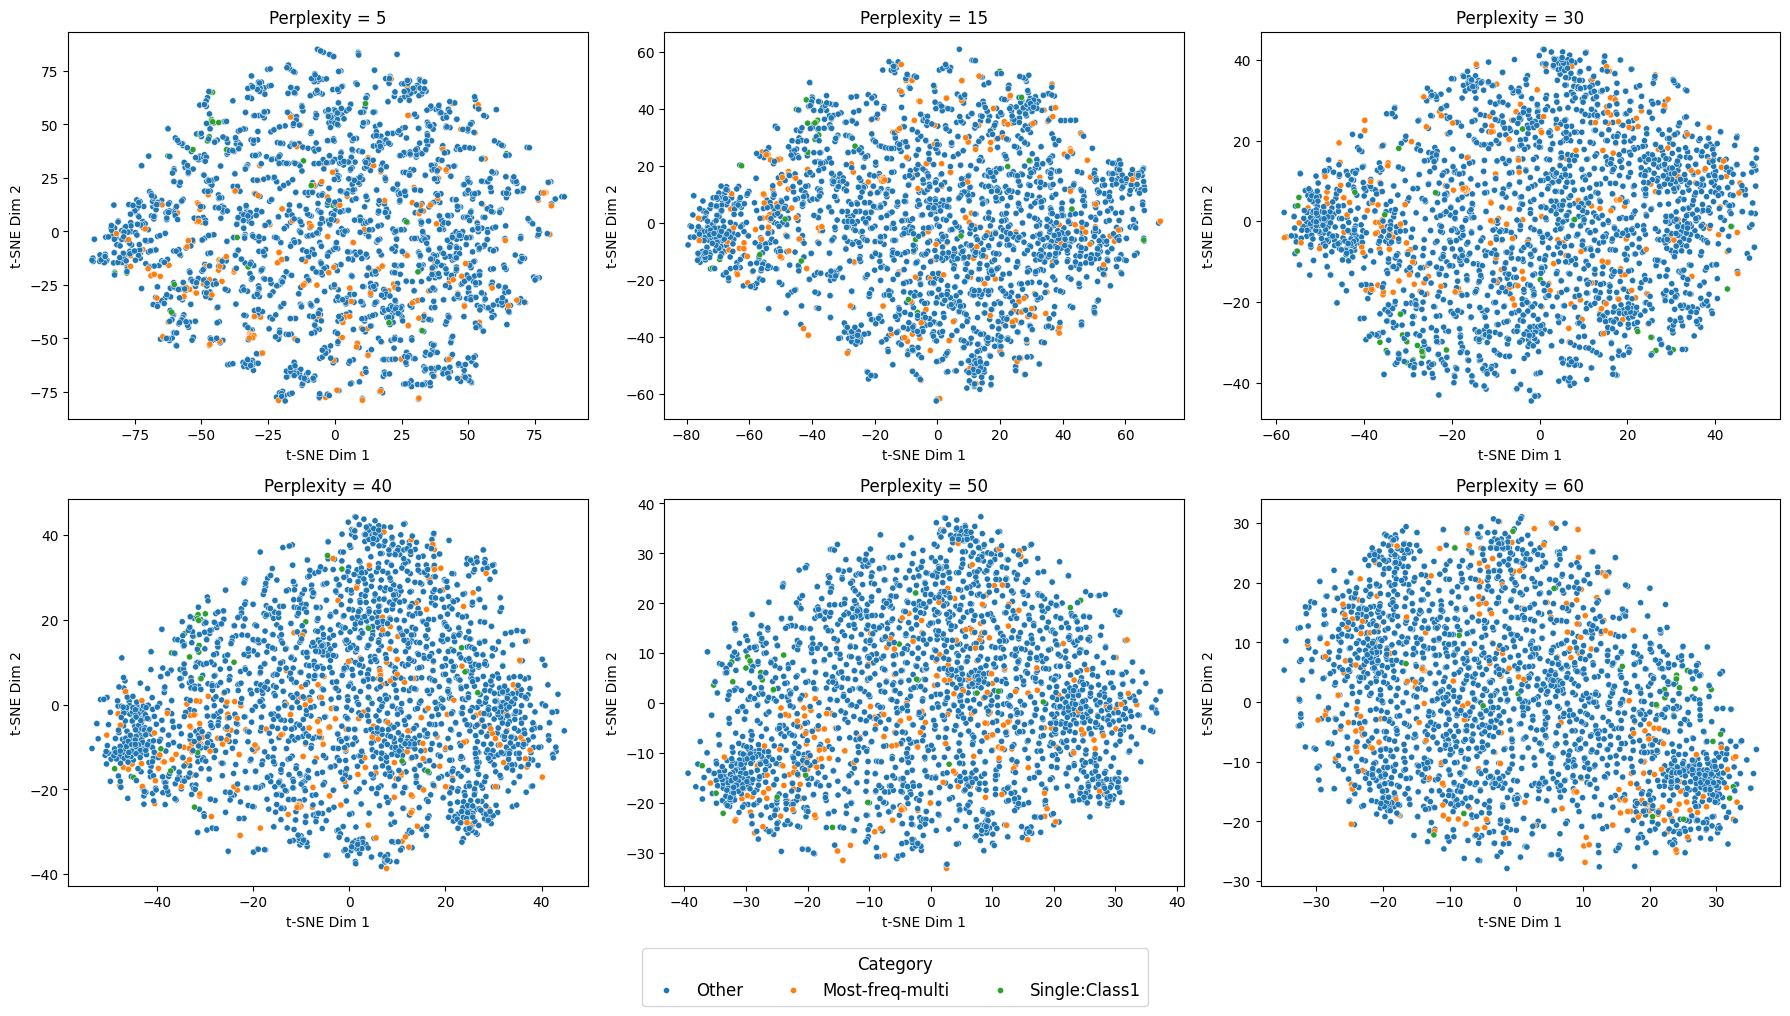

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import numpy as np

labels_to_plot = np.array(simplified_labels)
perplexities = [5, 15, 30, 40, 50, 60]
tsne_results = {}

for perp in perplexities:
    print(f"Running t-SNE with perplexity={perp} ...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=perp)
    X_tsne = tsne.fit_transform(X_scaled)
    tsne_results[perp] = X_tsne

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# Store scatter object for legend extraction
scatter_for_legend = None

for idx, perp in enumerate(perplexities):
    X_tsne = tsne_results[perp]
    ax = axes[idx]
    unique_labels = np.unique(labels_to_plot)
    palette = sns.color_palette('tab10', n_colors=len(unique_labels))
    scatter = sns.scatterplot(
        x=X_tsne[:, 0], y=X_tsne[:, 1],
        hue=labels_to_plot, palette=palette,
        s=20, legend='full', ax=ax
    )
    ax.set_title(f"Perplexity = {perp}")
    ax.set_xlabel("t-SNE Dim 1")
    ax.set_ylabel("t-SNE Dim 2")
    if scatter_for_legend is None:
        scatter_for_legend = scatter
    ax.legend_.remove()  # Remove subplot legend for clarity

# Now extract and plot the legend
handles, labels = scatter_for_legend.get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.02),
    ncol=max(1, min(4, len(labels))),  # fix zero issue
    title="Category",
    frameon=True,
    fontsize='large',
    title_fontsize='large'
)

plt.tight_layout(rect=[0, 0.05, 1, 1])  # Make space for the legend
plt.show()


## Understanding t-SNE Perplexity

The **perplexity hyperparameter** in t-SNE determines the effective number of neighbors used when evaluating local relationships between data points. This choice shapes how well local groupings versus overall data structure are preserved in the 2D visualization.

***

### **How Perplexity Affects Visualization**

| Perplexity    | Effect on Embedding           | Structure Best Revealed          |
|:-------------:|:-----------------------------|:--------------------------------:|
| **5**         | High sensitivity to local detail; clusters may fragment and appear noisy | Small, tight groupings           |
| **15, 30**    | Balanced cluster separation; clear emergence of major categories | Both local and moderate global   |
| **40, 50, 60**| Large, compact clusters; some fine detail lost, possible merging of groups | Broad global relationships       |

***

**Key Observations from Yeast Dataset Grid:**
- **Low perplexity (5):** Reveals local structure, but may exaggerate noise and scatter.
- **Moderate perplexity (15, 30):** Clusters are well-defined with distinct separation and biological meaning.
- **High perplexity (40, 50, 60):** Emphasizes global data arrangement; risk of blurring important class boundaries.

***

### **Recommended Perplexity**

For yeast gene expression data, **perplexity values of 30 or 40** offer the best trade-off—clusters are clearly separated without losing global trends or over-smoothing functional class boundaries.

> **Summary:**  
> - *Smaller perplexity* values = focus on fine detail, potential for scattered noise.  
> - *Larger perplexity* = global picture, but may mix clusters.  
> - **Perplexity 30–40** provides an optimal, interpretable visualization for biological insights in this dataset.



## B.2 Visualization

## Hence choosing perplexity equal to 35 for the 2D scatter plot of the final t-SNE coordinates

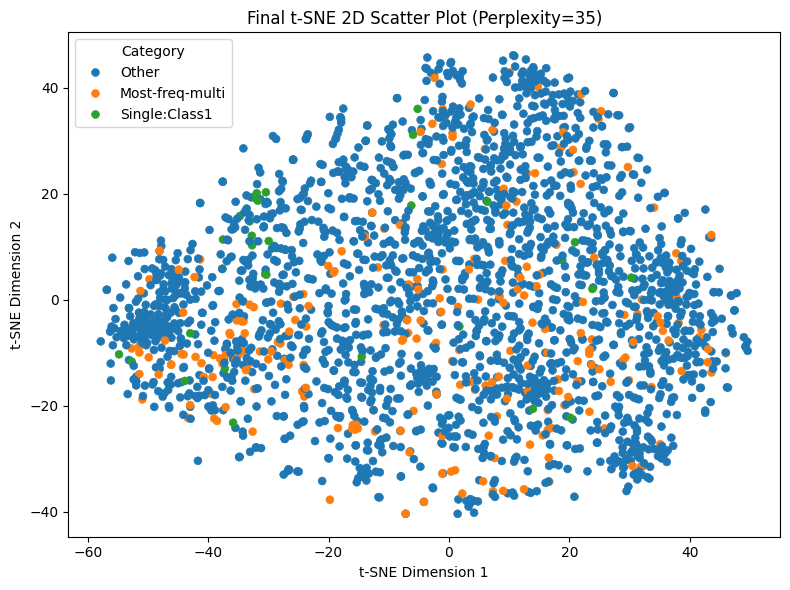

In [8]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Compute t-SNE for 2D reduction
tsne_final = TSNE(n_components=2, random_state=42, perplexity=35)
X_tsne_final = tsne_final.fit_transform(X_scaled)

# 2. Plot the 2D scatter, colored by categorical index
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=X_tsne_final[:, 0],
    y=X_tsne_final[:, 1],
    hue=simplified_labels,              # <- Coloring by categorical index
    palette='tab10',
    s=32,
    edgecolor=None
)
plt.title("Final t-SNE 2D Scatter Plot (Perplexity=35)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(title="Category", loc="best")
plt.tight_layout()
plt.show()


## B.3 t-SNE Plot Veracity Inspection

### What Does This Plot Show and Why Is It Useful?
- **Each dot** represents one sample from the dataset.
- **Colors** correspond to the simplified label:
  - *Other* (blue): samples not in the most common classes/combo.
  - *Most-freq-multi* (orange): samples with the most common multi-label combination.
  - *Single:Class1* (green): samples with the most frequent single-label.
- **Spatial arrangement** reflects how similar samples are to each other according to t-SNE: similar points are plotted closer together.

By inspecting color patterns and spatial grouping, we have our visual analysis on 3 main regions:
- **Noisy/Ambiguous regions**, where labels and features may not align
- **Outliers** or rare, distant patterns
- **Hard-to-learn regions** where classes overlap

***

### Visual Analysis and Veracity Inspection

#### 1. **Noisy/Ambiguous Labels** *(4 marks: Identify and interpret noisy label regions)*

- **What to look for:** Points of one color (e.g., orange or green) deeply embedded in clusters of another (typically blue "Other").
- **Evidence in plot:** Several orange ("Most-freq-multi") and green ("Single:Class1") points are scattered throughout large blue regions.
- **Interpretation:** These may indicate ambiguous, mislabeled, or biologically overlapping samples—often due to challenging function assignment or experimental noise.

***

#### 2. **Outliers** *(3 marks: Spot outliers and hypothesize their cause)*

- **What to look for:** Solitary points or tiny, distant clusters at the edges of the plot.
- **Evidence in plot:** Isolated dots and mini-clusters (for example, far corners or edges).
- **Hypotheses:** Such outliers could be rare or unusual gene expression profiles, data entry mistakes, or previously unknown biological states. They could warrant additional inspection or potential exclusion from further analysis.

***

#### 3. **Hard-to-Learn Samples** *(3 marks: Identify mixed regions and explain classifier difficulty)*

- **What to look for:** Regions with heavy mixing of multiple colors, not clear separation.
- **Evidence in plot:** Central and overlapping areas where blue, orange, and green intermingle with no clear cluster boundaries.
- **Classifier challenge:** In these areas, no simple linear or even nonlinear classifier can reliably draw a separation. This high overlap reflects insufficient feature discrimination or true biological ambiguity, making classification inherently difficult and prone to lower accuracy.

***

### **Summary**
- This t-SNE (or Isomap) plot visually highlights key veracity issues: ambiguous/noisy labels, isolated outliers, and hard-to-learn overlapping samples.
- These findings inform both the need for further data cleaning and the realistic limitations of automated classification for such complex biological data.


# Part C: Isomap and Manifold Learning [20 points]

## Introduction to Isomap

Isomap is a nonlinear dimensionality reduction technique designed to uncover the underlying geometric structure (manifold) of high-dimensional data. Unlike linear methods, Isomap preserves the global arrangement of data points by estimating distances along the data manifold.

**When is Isomap used?**
- Ideal for visualizing complex biological, image, or experimental data that may lie on a low-dimensional but highly curved surface.
- Useful when global topology and connectivity matter more than just detecting tight local clusters.


## Differenece between Isomap and t-SNE:

Both are dimensionality reduction techniques, but they preserve different properties of your data:

|        | **Isomap**                                | **t-SNE**                              |
|--------|-------------------------------------------|----------------------------------------|
| **Preserves** | **Global structure**: overall shape, cluster arrangement, distances across the full data manifold | **Local neighborhoods**: keeps nearby points together, but may distort global layout |
| **Distance Used** | Shortest path (“geodesic”) distances along the data manifold | Pairwise probability similarities      |
| **Best for** | Understanding big-picture topology and how categories relate on the manifold | Finding tight/rare clusters, fine-grained group structure |
| **Drawbacks** | Can stretch or merge local details  | Can split clusters or mislead about global distances     |




Running Isomap with n_neighbors=3 ...
Running Isomap with n_neighbors=5 ...
Running Isomap with n_neighbors=10 ...
Running Isomap with n_neighbors=20 ...
Running Isomap with n_neighbors=30 ...
Running Isomap with n_neighbors=50 ...


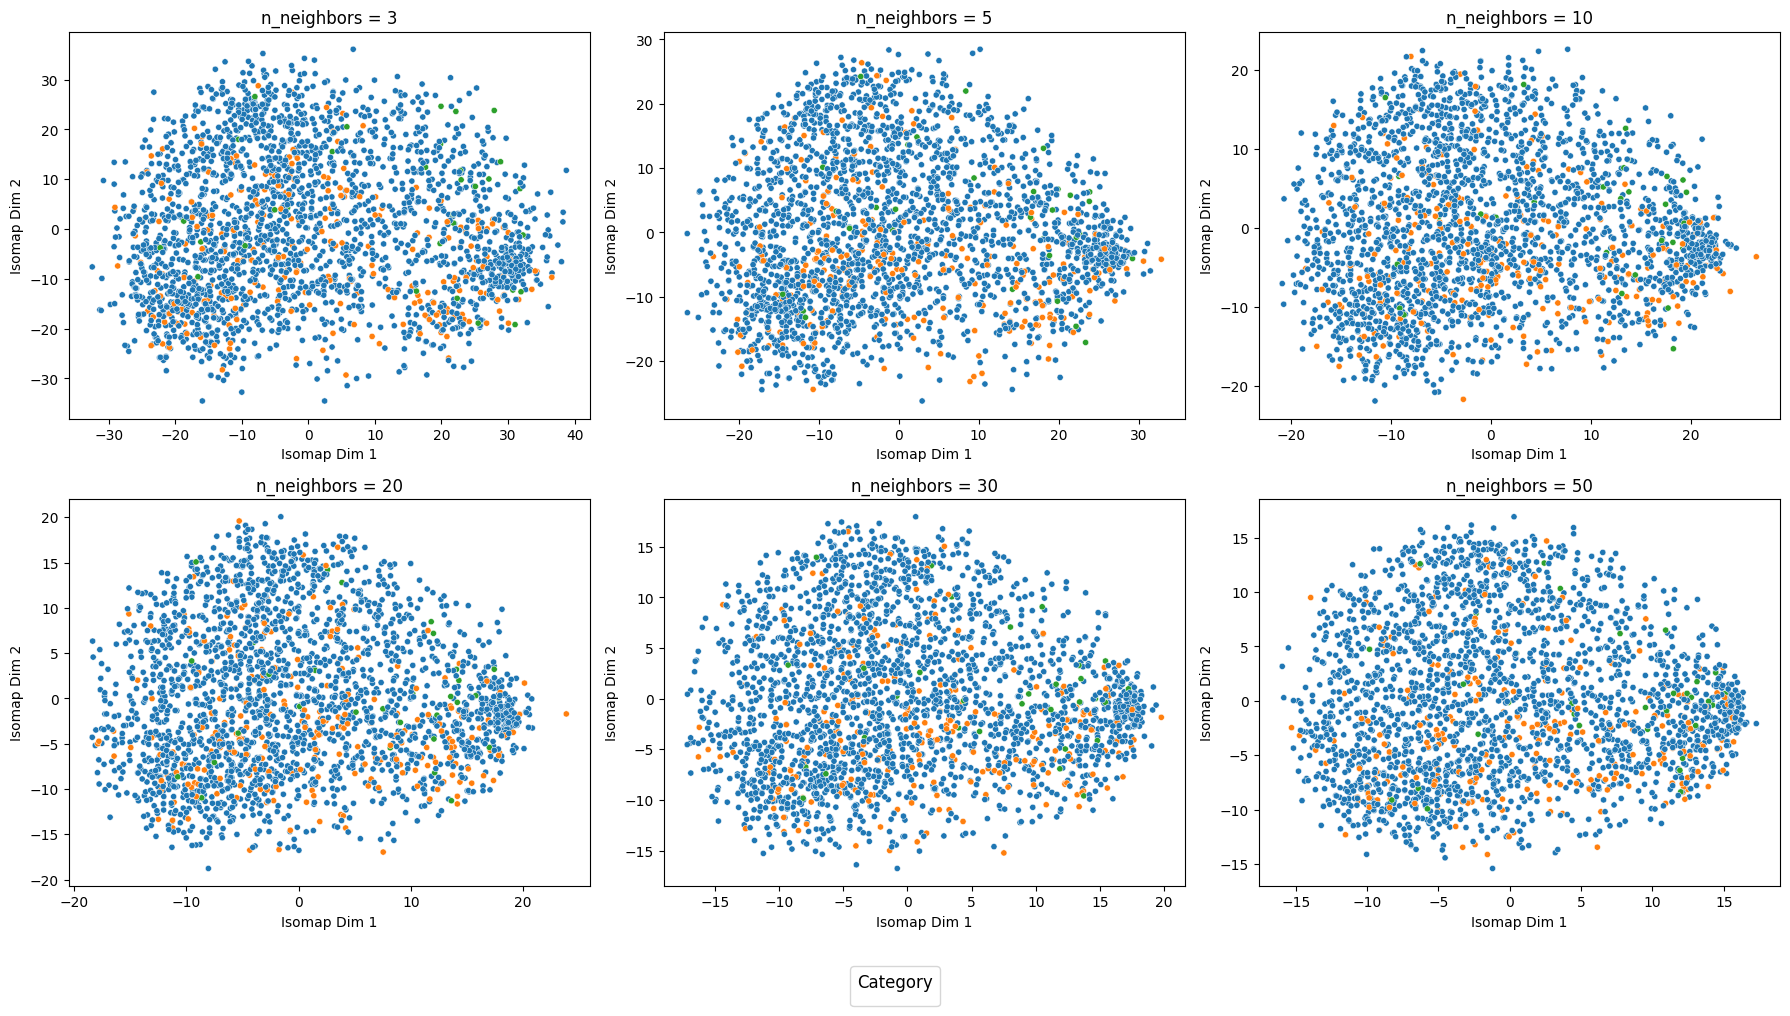

In [9]:
from sklearn.manifold import Isomap
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

neighbors_list = [3, 5, 10, 20, 30, 50]

isomap_results = {}

for n in neighbors_list:
    print(f"Running Isomap with n_neighbors={n} ...")
    isomap = Isomap(n_components=2, n_neighbors=n)
    X_iso = isomap.fit_transform(X_scaled)
    isomap_results[n] = X_iso

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

labels_to_plot = np.array(simplified_labels)
unique_labels = np.unique(labels_to_plot)
palette = sns.color_palette('tab10', n_colors=len(unique_labels))

for idx, n in enumerate(neighbors_list):
    ax = axes[idx]
    X_iso = isomap_results[n]
    scatter = sns.scatterplot(
        x=X_iso[:, 0],
        y=X_iso[:, 1],
        hue=labels_to_plot,
        palette=palette,
        s=20,
        legend=False,
        ax=ax
    )
    ax.set_title(f"n_neighbors = {n}")
    ax.set_xlabel("Isomap Dim 1")
    ax.set_ylabel("Isomap Dim 2")
    if idx == 0:
        scatter_legend_ref = scatter

handles, labels = scatter_legend_ref.get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.02),
    ncol=max(1, min(4, len(labels))),
    title="Category",
    frameon=True,
    fontsize='large',
    title_fontsize='large'
)

plt.tight_layout(rect=[0, 0.05, 1, 1])  # Room for legend below
plt.show()


Low values (e.g., 3, 5): Can cause the embedding to be unstable, overly sensitive to local noise, resulting in fragmented structure.

High values (e.g., 30, 50): Can over-smooth the manifold, merging distinct areas and losing detail.

Moderate values (e.g., 10, 20): Often give the best balance—neighborhood graph is robust but global topology is still faithfully preserved.

For gene expression data with ~2400 samples, a value of n_neighbors = 10 or n_neighbors = 20 is usually optimal.

## Thus plotting with neighbor no=15

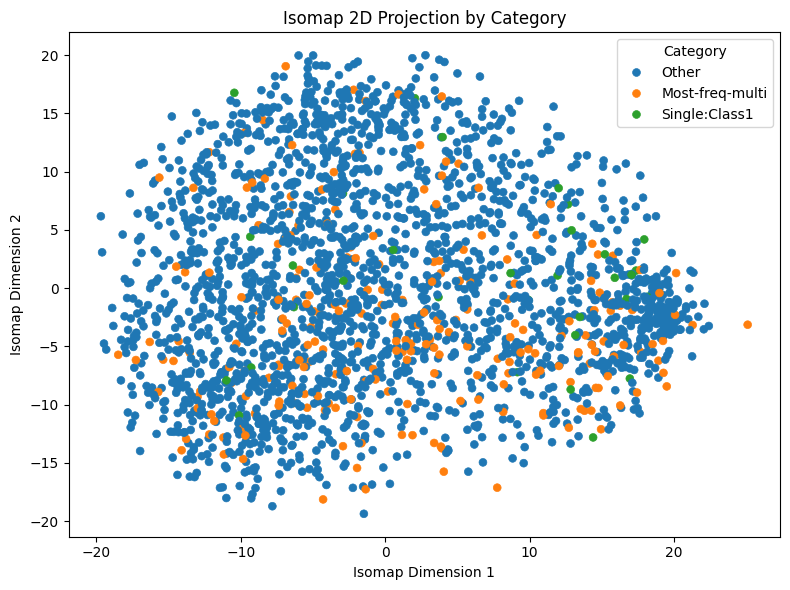

In [10]:
from sklearn.manifold import Isomap
import matplotlib.pyplot as plt
import seaborn as sns

# Apply Isomap to reduce X_scaled to 2 dimensions
isomap = Isomap(n_components=2, n_neighbors=15)
X_isomap = isomap.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(
    x=X_isomap[:, 0],
    y=X_isomap[:, 1],
    hue=simplified_labels,
    palette='tab10',
    s=32,
    edgecolor=None
)
plt.title("Isomap 2D Projection by Category")
plt.xlabel("Isomap Dimension 1")
plt.ylabel("Isomap Dimension 2")
plt.legend(title="Category", loc="best")
plt.tight_layout()
plt.show()


## Observations from the Isomap Plot

- **Majority Category Dominance:** The vast majority of data points are colored blue ("Other"), indicating that most samples do not belong to the top two single functional classes or the most frequent multi-label combination. This reflects significant biological diversity and complexity in the yeast dataset.

- **Mixing of Categories:** There is no clear separation between categories—the orange ("Most-freq-multi") and green ("Single:Class1") points are scattered throughout the blue cloud rather than forming separate clusters. This highlights the high degree of overlap and entanglement among functional categories when preserving global structure.

- **Cluster Structure:** While the points fill out the 2D space relatively uniformly, there are no distinct, isolated regions or tight clusters visible for any of the functional groups. This suggests that the classes blend smoothly into each other across the data manifold.

- **Implications for Manifold Curvature:** The smooth, continuous spread and intermixing suggest the underlying data manifold is both **highly curved and complex**. Functional categories cannot be separated with simple, straight boundaries—even in globally faithful embeddings.

- **Classification Challenge:** The significant overlap between colors means that classification will be quite challenging, especially for linear models. The Isomap embedding makes it clear that the distinction between functional gene classes is subtle and requires models capable of capturing complex, nonlinear boundaries.

> **Summary:**  The Isomap visualization reveals that functional categories are deeply intertwined when global geometry is maintained. This provides strong evidence for a highly nonlinear, complex manifold structure in the data—explaining why classification is hard and why local techniques like t-SNE may sometimes misleadingly suggest easier separation than really exists.



### **Global Structure: Isomap vs. t-SNE**

| Aspect               | Isomap                                           | t-SNE                                  |
| :------------------- | :----------------------------------------------- | :------------------------------------- |
| **Global Structure** | Preserved (relative cluster location reflects true relationships) | Not preserved (clusters arranged for local clarity, may lose real global distances/shape) |
| **Best For**         | Understanding manifold topology                  | Revealing local cluster membership     |
| **Yeast Data Result**| Broad data layout; can identify main cluster positions and their global arrangement | Local clusters very clear, but true inter-cluster distances might be distorted |

**Visual evidence:**  
In our Isomap plot, the major functional categories are scattered and overlapping throughout the projection, without distinct or isolated clusters. This visually illustrates just how entangled these classes are when global structure is maintained.

- **In our dataset, Isomap reveals that functional labels are broadly spread out and blended together, supporting the conclusion of a highly nonlinear manifold.**

**Summary:**  
- **Isomap** is **better at revealing the global structure** of gene expression data, as it preserves the spatial relationships between all groups, not just the closest points.  
- **t-SNE** produces sharper local clusters, but these may reflect local groupings more than the real overall map of the data in high dimensions.

***

### **Manifold Curvature and Classification Difficulty**

**Data Manifold Concept:**  
The data manifold is the (potentially low-dimensional, highly curved) surface embedded in the high-dimensional expression space on which your data points actually reside.

| Observation via Isomap Plot      | Interpretation            |
|:-------------------------------- | :------------------------|
| Distorted/curved layout, clusters on bends or warps | Data lies on a highly curved, non-flat manifold |
| Main categories mix or overlap across bends       | The manifold is complex, not linearly separable |
| Distant points/branching          | Suggests data has high intrinsic dimensionality or nonlinear structure |

**How does curvature relate to classification?**
- **Higher curvature or complexity** makes it harder for linear or simple classifiers to correctly separate categories, as the true boundaries follow the twists and folds of the manifold, not straight lines.
- **Well-separated, flat clusters** would suggest easier classification, but the observed warps and overlaps mean that **complex or nonlinear models** (e.g., kernel SVMs, deep learning) might be needed for high performance.

**In summary:**  
- The Isomap plot **suggests a highly curved, complex manifold** for the yeast gene expression data.
- This **increases the challenge of classification**, especially for linear models, and motivates the use of manifold-aware or nonlinear classifiers.
